In [1]:
import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.datasets as datasets
from art.attacks.evasion import BasicIterativeMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from region_based_classifier import RegionBasedClassifier
from util import dataset2tensor, get_correct_examples

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cuda
CPU threads: 24


In [4]:
PATH_DATA = 'data'
PATH_RESULTS = os.path.join('results', 'mnist_base_model.pt')
BATCH_SIZE = 128
EPOCHS = 40
N_ADV = 2000

In [67]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH_DATA, train=False, download=True, transform=transforms)

# From PyTorch dataset to Numpy array
tensor_X_train, tensor_y_train = dataset2tensor(dataset_train)
X_train = tensor_X_train.cpu().detach().numpy()
y_train = tensor_y_train.cpu().detach().numpy()
tensor_X_test, tensor_y_test = dataset2tensor(dataset_test)
X_test = tensor_X_train.cpu().detach().numpy()
y_test = tensor_y_train.cpu().detach().numpy()

# Split model training set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=5000)
dataset_train = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.int64))

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
print(len(dataset_train))
print(dataset_test.data.size())

55000
torch.Size([10000, 28, 28])


## Train point-based classifier

In [7]:
# Create Neural Network model
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(9216, 200)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(200, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [8]:
# Testing outputs
model = BaseModel().to(device)
model.eval()
it = iter(dataloader_train)
x, y = next(it)
x = x.to(device)
output0 = model(x)
print(output0.size())

seq1 = nn.Sequential(*list(model.children())).to(device)
seq1.eval()
output1 = seq1(x)
print(output1.size())
print(torch.equal(output0, output1))

seq2 = nn.Sequential(*list(model.children())[:-1]).to(device)
seq2.eval()
output2 = seq2(x)
print(output2.size())
print(torch.equal(output0, output2))
print(output2[:3])

torch.Size([128, 10])
torch.Size([128, 10])
True
torch.Size([128, 10])
False
tensor([[-0.0562, -0.0003,  0.0475,  0.0232,  0.0720,  0.0374,  0.0243,  0.0071,
          0.0207, -0.0246],
        [-0.0434, -0.0157,  0.0406,  0.0046,  0.0856,  0.0425,  0.0040,  0.0189,
          0.0172, -0.0221],
        [-0.0603, -0.0247,  0.0303,  0.0118,  0.0795,  0.0449,  0.0103,  0.0129,
          0.0081, -0.0141]], device='cuda:0', grad_fn=<SliceBackward>)


In [9]:
def train(model, loader, loss, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        outputs = model(x)
        l = loss(outputs, y)
        l.backward()
        optimizer.step()

        # for display
        total_loss += l.item() * batch_size
        preds = outputs.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [10]:
def validate(model, loader, loss, device=device):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            outputs = model(x)
            l = loss(outputs, y)
            total_loss += l.item() * batch_size
            preds = outputs.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [11]:
def predict(model, X, batch_size=BATCH_SIZE, device=device):
    model.eval()
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    tensor_pred = -torch.ones(len(X), dtype=torch.int64)
    
    start = 0
    with torch.no_grad():
        for x in loader:
            x = x[0].to(device)
            n = x.size(0)
            end = start + n
            outputs = model(x)
            tensor_pred[start:end] = outputs.max(1)[1].type(torch.int64)
            start += n

    return tensor_pred

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.CrossEntropyLoss()

In [13]:
# DO NOT RUN THIS IF YOU DON'T NEED RETRAIN!
# since = time.time()
# for epoch in range(EPOCHS):
#     start = time.time()
#     tr_loss, tr_acc = train(model, dataloader_train, loss, optimizer)
#     va_loss, va_acc = validate(model, dataloader_test, loss)
    
#     time_elapsed = time.time() - start
#     print(('{:2d}/{:d}[{:s}] Train Loss: {:.4f} Acc: {:.4f}%, ' +
#         'Test Loss: {:.4f} Acc: {:.4f}%').format(
#             epoch+1, EPOCHS, str(datetime.timedelta(seconds=time_elapsed)),
#             tr_loss, tr_acc*100.,
#             va_loss, va_acc*100.))
    
# time_elapsed = time.time() - since
# print('Total run time: {:.0f}m {:.1f}s'.format(
#     time_elapsed // 60,
#     time_elapsed % 60))

In [14]:
# DO NOT RUN THIS IF YOU DON'T NEED RETRAIN!
# if not os.path.exists('results'):
#     os.makedirs('results')

# torch.save(model.state_dict(), PATH_RESULTS)

In [15]:
# Load model from saved file
model.load_state_dict(torch.load(PATH_RESULTS))

_, acc_test = validate(model, dataloader_test, loss)
print('Test set accuracy: {:.4f}'.format(acc_test*100))

Test set accuracy: 98.2200


## Remove missclassified samples

In [16]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss)
print('Accuracy on {} filtered training examples: {:.4f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss)
print('Accuracy on {} filtered test examples: {:.4f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 55000
Accuracy on 54457 filtered training examples: 100.0000%
Test set: 10000
Accuracy on 9822 filtered test examples: 100.0000%


## Create adversarial examples 

In [17]:
classifier = PyTorchClassifier(
    model=model, 
    loss=loss, 
    input_shape=(1, 28, 28), 
    optimizer=optimizer,
    nb_classes=10,
    clip_values=(0.0, 1.0),
    device_type=device
)

# attack = FastGradientMethod(estimator=classifier, eps=0.2)
attack = BasicIterativeMethod(estimator=classifier, eps=0.2)

In [18]:
# Prepare dataset for adversarial examples
n = len(dataset_test_perfect)
indices = torch.randperm(n)[:N_ADV]

pt_subset_X = tensor_test_X[indices]  # PyTorch Tensor
pt_subset_y = tensor_test_y[indices]

subset_X = pt_subset_X.cpu().detach().numpy()
subset_y = pt_subset_y.cpu().detach().numpy()

In [19]:
# Create adversarial examples
subset_pred = np.argmax(classifier.predict(subset_X), axis=1)
accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on clean examples: {:.4f}%".format(accuracy * 100))

# Generate adversarial examples
subset_adv = attack.generate(x=subset_X)
subset_pred = np.argmax(classifier.predict(subset_adv), axis=1)

accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on adversarial examples: {:.4f}%".format(accuracy * 100))

PGD - Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Model accuracy on clean examples: 100.0000%


/home/lukec/.local/lib/python3.6/site-packages/art/estimators/classification/pytorch.py:525: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/home/lukec/.local/lib/python3.6/site-packages/art/estimators/classification/pytorch.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Model accuracy on adversarial examples: 10.8000%


## MagNet

In [105]:
from torchvision.utils import make_grid
from magnet import Autoencoder1, Autoencoder2, MagNetDetector, MagNetAutoencoderReformer, MagNetNoiseReformer

In [106]:
autoencoder1 = Autoencoder1(n_channel=1)
detector1 = MagNetDetector(
    model=autoencoder1,
    lr=0.001,
    batch_size=256,
    weight_decay=1e-09,
    x_min=0.0,
    x_max=1.0,
    noise_strength=0.025,
    p=2,
    device=device)

In [107]:
detector1.fit(X_train, epochs=50, disable_progress_bar=False)

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


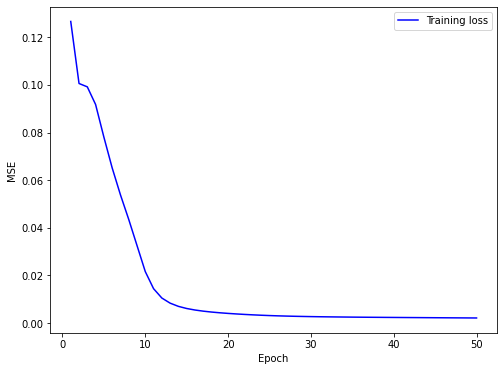

In [108]:
hitstory_loss = detector1.history_train_loss
n = len(hitstory_loss)

plt.figure(figsize=(8, 6))
x = np.arange(1, n+1)
plt.plot(x, hitstory_loss, c='blue', label='Training loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [109]:
mse = detector1.score(X_val)
print('MSE training set: {:.6f}, validation set: {:.6f}'.format(hitstory_loss[-1], mse))

MSE training set: 0.002116, validation set: 0.002088


In [110]:
X_test_ae = detector1.predict(X_test)

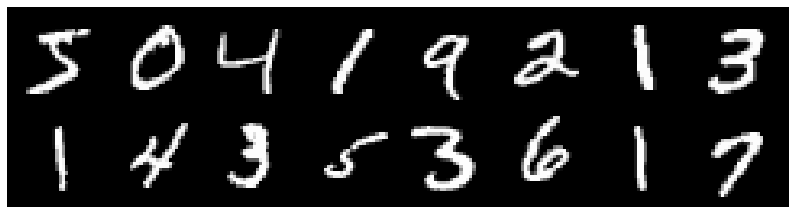

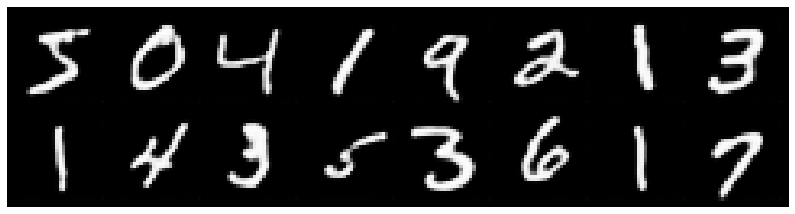

In [111]:
grid_image = make_grid(torch.from_numpy(X_test[:16])).permute(1, 2, 0).detach().numpy()
plt.figure(figsize=(14, 4))
plt.imshow(grid_image)
plt.axis('off')
plt.show()

grid_image_ae = make_grid(torch.from_numpy(X_test_ae[:16])).permute(1, 2, 0).detach().numpy()
plt.figure(figsize=(14, 4))
plt.imshow(grid_image_ae)
plt.axis('off')
plt.show()

In [121]:
threshold = detector1.search_threshold(X_val)
detector1.threshold

0.009277677

## Testing Jensen–Shannon divergence

In [145]:
def get_m(p, q):
    return (p + q) * 0.5

def kl_divergence(p, q):
    """Kullback–Leibler divergence"""
    return np.sum(p * np.log(p/q), axis=1)

def js_divergence(p, q):
    """Jensen–Shannon divergence"""
    m = get_m(p, q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

In [146]:
p = np.random.dirichlet(np.ones(10), size=5).astype(np.float32)
q = np.random.dirichlet(np.ones(10), size=5).astype(np.float32)

print(js_divergence(p, q))
print(js_divergence(q, p))
print(js_divergence(p, p))
print(js_divergence(q, q))
print(kl_divergence(p, q))
print(kl_divergence(q, p))

[0.18435758 0.32233176 0.13033664 0.14401713 0.1575371 ]
[0.18435758 0.32233176 0.13033664 0.14401713 0.1575371 ]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[1.1332982 1.8530356 0.5732334 0.6190204 0.6801647]
[0.7096516 1.9254757 0.5603643 0.6533967 0.7313552]


In [159]:
labels = np.zeros(10, dtype=np.bool)
print(labels)
result = np.random.randint(0, 2, size=10, dtype=np.bool)
print(result)
labels = np.logical_or(labels, result)
print(labels)
result = np.random.randint(0, 2, size=10, dtype=np.bool)
labels = np.logical_or(labels, result)
print(result)
print(labels)


[False False False False False False False False False False]
[ True False False False  True  True False  True False  True]
[ True False False False  True  True False  True False  True]
[False False  True  True False  True False  True False  True]
[ True False  True  True  True  True False  True False  True]


In [163]:
np.sum(np.equal(result, labels))

8

In [166]:
labels.shape

(10,)